In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pickle
sys.path.append('../../')
print(sys.path)
import IPython.display as ipd
import numpy as np
from tools.libaudio.feature import melspectrogram
from tools.libaudio.display import show_spec, show_mel
from mlutils.utils import plot, plots, to_onehot
from models.mlmodeldic import best_model_path_and_settings
import torch
from tts.Alternative.neuravoice import CharToMel
from tts.Alternative.train import train_char2mel
from tts.Alternative.dataset import NeuraVoiceDataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from models.phoneme import Phoneme43
import time

['/var/Sources/experiments/core/tts/Alternative', '/home/kaz/anaconda3/envs/core/lib/python37.zip', '/home/kaz/anaconda3/envs/core/lib/python3.7', '/home/kaz/anaconda3/envs/core/lib/python3.7/lib-dynload', '', '/home/kaz/.local/lib/python3.7/site-packages', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages/Mako-1.0.7-py3.7.egg', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages/IPython/extensions', '/home/kaz/.ipython', '../../']


####  Sequence Generator with location-based Attention

```
x: input sequence
y: mel spectrum sequence
U: char length
c: char sequence
T: timestep length of input x
wt: window vector into c at timestep t
φ(t, u): window weight of cu at timestep t
αt: parameters control the importance of the window within the mixture
βt: parameters control the width of the window
κt: parameters control the location of the window
(eq.46): discrete convolution with a mixture of K Gaussian function

xt ∈ R×R×{0,1}

h1t = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h)

(αhat_t, βhat_t, khat_t) = Wh1p ht^1 + bp  # output of the first hidden layer

αt = exp(αhat_t)  # importance of the window
βt = exp(βhat_t)  # width of the window
κt = κt-1 + exp(κhat_t)  # location of the window (how far to slide each window)

φ(t, u) = Σk=1->K αkt*exp(-βkt(κkt-u)^2)  # mixture of K Gaussian


cf. 
normal distribution
N(X|μ,σ2) = 1/(2πσ2)^1/2 exp{-1/2σ2(x-μ)2}

mixture gaussians
p(x) = Σk=1->K πk N(X|μk,Σk)  # where πk:mixing coefficient, μk:mean, Σk:covariance, N(X|μk,Σk):mixture component
p(x) = Σk=1->K πk (1/(2π)^D/2 1/|Σ|^1/2) exp{-1/2(x-μ)^T Σ^-1(x-μ)}  # where Σ:DxD dim covariance matrix, |Σ|:det Σ

wt = Σu=1->U φ(t, u)*cu  # the soft window into c at timestep t

hnt = H(Wihn xt + Whn-1hn hnt-1 + Whnhn hnt-1 + Wwhn wt + bnh)

yˆtˆ = (eˆt,{wˆj_t,μˆJ_t,σˆj_t,ρˆj_t}^M_j=1) = by + Σn=1->N Whny hnt
yt = Y(yˆt)

et = 1 / (1 + exp(eˆt)) ⇒ et∈(0,1) : stroke probability
πtj = exp(πtj) / (Σj't=1->M exp(πtj)) ⇒πtj∈(0,1), Σπtj=1 : mixture weights
μjt = μˆjt ⇒ μjt∈R : means
σtj = exp(σˆtj) ⇒ σˆtj > 0 : std
pjt = tanh(pˆtj) ⇒ pˆtj∈(0,1) : correlations

Pr(x|c) = ∏t=1->T Pr(xt+1|yt)
L(x) = -log Pr(x|c)
```

In [2]:
# ver.1 hidden 256 out 256
# ver.2 hidden 256 out 256 
# ver.3 hidden 512 out 512, trainable init param
# ver.4 hidden 512 out 512, trainable init param, batchnorm, relu
# *ver.5 hidden 512 out 512, trainable init param, batchnorm
# lr 0.003

In [3]:
model_version = 6
batch_size = 1
sample_index = 5
model_name = f'char2mel_{batch_size}_ver{model_version}_single{sample_index}'
cuda = 1

In [4]:
dataset = NeuraVoiceDataset(batch_size=batch_size)
sampler = SubsetRandomSampler([sample_index])
loader = DataLoader(
    dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.char_to_mel, drop_last=False, num_workers=1, sampler=sampler)
[d for d in loader]

[(tensor([[[4.3469e-01, 1.9852e-04, 3.2515e-05,  ..., 1.9618e-06,
            3.0190e-06, 4.4162e-06],
           [3.8609e-01, 1.5164e-04, 4.6574e-05,  ..., 1.2890e-06,
            1.9772e-06, 2.8552e-06],
           [2.7793e-01, 2.7050e-04, 8.2761e-05,  ..., 3.3026e-07,
            4.8114e-07, 6.1693e-07],
           ...,
           [4.7460e-02, 1.1705e-03, 2.2462e-03,  ..., 1.9071e-07,
            1.3145e-07, 4.9778e-08],
           [3.3239e-02, 9.7881e-04, 2.3947e-03,  ..., 6.5638e-07,
            4.6616e-07, 1.6400e-07],
           [2.6419e-02, 1.2667e-03, 2.6865e-03,  ..., 1.1643e-06,
            8.4390e-07, 2.8885e-07]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 1,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [1, 0, 0,  ..., 0, 0, 0],
           [0, 1, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]]))]

In [5]:
cx = None
for d in loader:
    cx = d[1]
phonemes = [np.argmax(a) for a in cx.squeeze(0).numpy()]
Phoneme43.to_phoneme_names(phonemes)

['s',
 'u',
 'm',
 'aH',
 't',
 'o',
 'f',
 'o',
 'N',
 'k',
 'a',
 'r',
 'a',
 'f',
 'iH',
 'ch',
 'aH',
 'f',
 'o',
 'N',
 'm',
 'a',
 'd',
 'e',
 'm',
 'a',
 'r',
 'u',
 'ch',
 'i',
 'd',
 'e',
 'b',
 'a',
 'i',
 's',
 'u',
 'n',
 'i',
 't',
 'a',
 'i',
 'oH']

In [6]:
text = 'スマートフォンからフィーチャーフォンまでマルチデバイスに対応'

In [7]:
model_path, settings = best_model_path_and_settings(model_name, 'loss_ave', is_lower_better=True)
model_path, settings

('/diskB/6/out/models/char2mel/char2mel_1_ver6_single5_epoch500_lr0.003_loss1-77_48',
 {'lr': 0.003,
  'n_epoch': 500,
  'encode_type': 'onehot',
  'hidden_size': 512,
  'K': 10,
  'out_size': 512})

In [8]:
device = f'cuda:{cuda}'

In [9]:
use_best_model = True

In [10]:
if model_path and use_best_model: model = CharToMel.init_from_settings(settings, model_path, device=device, **{'version': model_version})
else:                             model = CharToMel(encode_type='onehot', K=10, hidden_size=512, out_size=512, version=model_version, device=device)

model version 6
Trainable Parameters: 5.600 million


In [11]:
losses, loss_aves, model = train_char2mel(
    model, loader, n_epoch=500, model_name=model_name, device=device, check_interval=100, lr=0.0001, verbose=False)

epoch 99/499 iter: 0/7614 total_iter: 100-- loss ave: 0.4756 loss: 0.01 -- elapse: 12m 28s speed 0.1 steps/sec
model name:char2mel_1_ver6_single5 id:5caee5bc1446828794226deb saving path generated.
best score. save model.
trying to save model parameters odict_keys(['h1_0', 'h2_0', 'h3_0', 'w_0', 'H1.weight_ih', 'H1.weight_hh', 'H1.bias_ih', 'H1.bias_hh', 'H2.weight_ih', 'H2.weight_hh', 'H2.bias_ih', 'H2.bias_hh', 'H3.weight_ih', 'H3.weight_hh', 'H3.bias_ih', 'H3.bias_hh', 'window.Wh1p.weight', 'window.Wh1p.bias', 'Wh1y.weight', 'Wh1y.bias', 'Wh2y.weight', 'Wh2y.bias', 'Wh3y.weight', 'Wh3y.bias', 'Y.weight', 'Y.bias']) to /diskB/6/out/models/char2mel/char2mel_1_ver6_single5_epoch500_lr0.003_loss0-476_49 ..
epoch 199/499 iter: 0/7614 total_iter: 200-- loss ave: 0.2423 loss: 0.00 -- elapse: 24m 57s speed 0.1 steps/sec
model name:char2mel_1_ver6_single5 id:5caee8a91446828794226dec saving path generated.
best score. save model.
trying to save model parameters odict_keys(['h1_0', 'h2_0', 'h3_

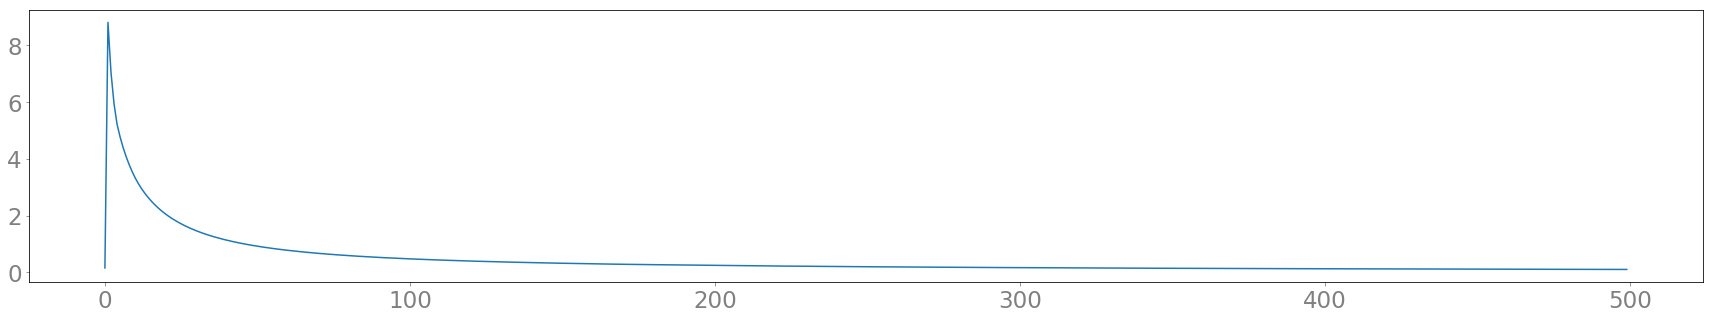

In [12]:
plot(loss_aves)

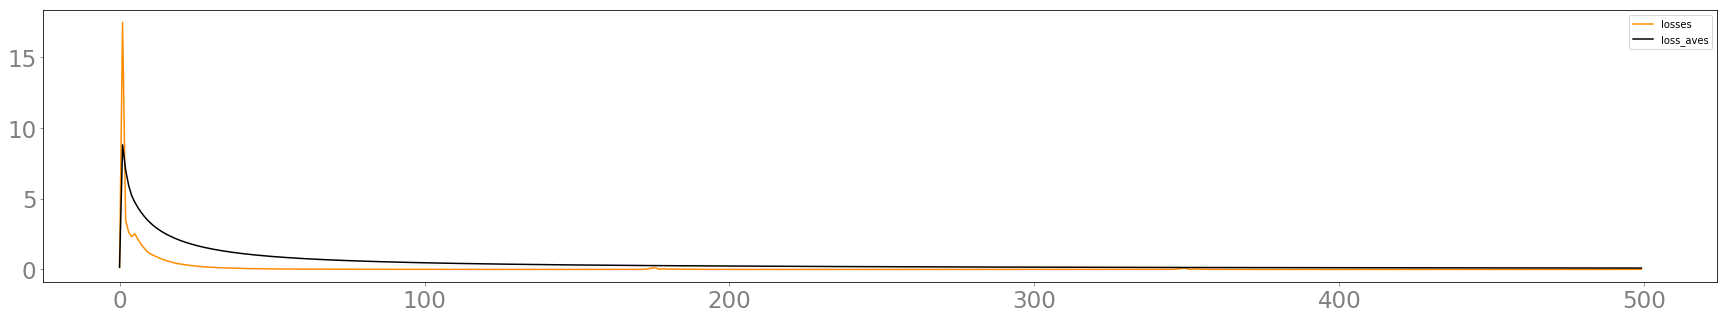

In [13]:
plots([losses, loss_aves], labels=['losses', 'loss_aves'])